# 03. DQN example with CartPole

## Colab 용 package 설치 코드

In [1]:
!pip install gym
!pip install JSAnimation

### package import

In [1]:
# The typical imports
from IPython.display import clear_output
import gym
import numpy as np
import matplotlib.pyplot as plt
import random

from collections import deque

%matplotlib inline

import tensorflow as tf

np.random.seed(285)
tf.set_random_seed(285)

print("tensorflow version: ", tf.__version__)
print("gym version: ", gym.__version__)

/home/khkim/anaconda3/envs/sonic/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


tensorflow version:  1.7.0
gym version:  0.10.5


### 게임 화면을 보여주기 위한 함수

In [2]:
# Imports specifically so we can render outputs in Jupyter.
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
from IPython.display import display

def display_frames_as_gif(frames):
    """
    Displays a list of frames as a gif, with controls
    """
    #plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    display(display_animation(anim, default_mode='loop'))

### 그래프를 그리기 위한 함수

In [3]:
def plot(frame_idx, episode, rewards, losses):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('episode %s. reward: %s' % (episode, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)
    plt.show()

<script src='https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.4/MathJax.js?config=TeX-MML-AM_CHTML' async></script>
## CartPole
CartPole is game that ballance pole on the car.  
this game's observation is $x$, $x\prime$, $\theta$, $\theta\prime$

$x$ : 카트의 위치  
$\theta$ : 막대의 각도  
$x\prime$ : 카트의 속도  
$\theta\prime$ : 막대의 각속도  

Action is **Left** or **Right**  

모든 step 마다 보상을 1 받으며, 아래 3가지 경우에 episode가 끝난다.
1. 카트가 바깥으로 나갈 때
2. 기둥이 너무 많이 기울었을 때
3. 200 step 지났을 때  
<img src="./img/cartpole.gif" width="60%" align="left"> 

In [4]:
# CartPole 환경
env_id = "CartPole-v0"
env = gym.make(env_id)

state_size = env.observation_space.shape[0]
action_size = env.action_space.n
print("Observation size : ", state_size)
print("Action size : ", action_size)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Observation size :  4
Action size :  2


## DQN Agent

### Replay Buffer

In [5]:
from collections import deque

state = env.reset()
action = env.action_space.sample()
next_state, reward, done, _ = env.step(action)

print("state_size:", np.shape(state))
print("next_state_size:", np.shape(next_state))

# state, next_state의 차원을 늘림. batch 단위로 묶을 때 size를 맞추기 위해
# 참고) np.expand_dims( array, axis=0 )
state = np.expand_dims(state, axis=0)
next_state = np.expand_dims(next_state, axis=0)

print("state_size:", np.shape(state))
print("next_state_size:", np.shape(next_state))

state_size: (4,)
next_state_size: (4,)
state_size: (1, 4)
next_state_size: (1, 4)


In [6]:
#  deque buffer 생성
buffer = deque(maxlen=1000)

transition = (state, action, reward, next_state, done)
buffer.append(transition)

print(np.shape(buffer))
print(buffer)

(1, 5)
deque([(array([[ 0.04131817, -0.00027645,  0.04726517,  0.04284331]]), 0, 1.0, array([[ 0.04131264, -0.19604319,  0.04812204,  0.35005625]]), False)], maxlen=1000)


In [7]:
# buffer에서 batch size만큼 sampling
for i in range(5):
    buffer.append(transition)
    
# 참고) random.sample(list, sample 수)
transitions = random.sample(buffer, 3)
print(transitions)

state, action, reward, next_state, done = [], [], [], [], []
for t in transitions:
    state.append(t[0])
    action.append(t[1])
    reward.append(t[2])
    next_state.append(t[3])
    done.append(t[4])
    
state = np.squeeze(state)
next_state = np.squeeze(next_state)

print(np.shape(state))
print(next_state)
print(action)
print(reward)
print(done)

[(array([[ 0.04131817, -0.00027645,  0.04726517,  0.04284331]]), 0, 1.0, array([[ 0.04131264, -0.19604319,  0.04812204,  0.35005625]]), False), (array([[ 0.04131817, -0.00027645,  0.04726517,  0.04284331]]), 0, 1.0, array([[ 0.04131264, -0.19604319,  0.04812204,  0.35005625]]), False), (array([[ 0.04131817, -0.00027645,  0.04726517,  0.04284331]]), 0, 1.0, array([[ 0.04131264, -0.19604319,  0.04812204,  0.35005625]]), False)]
(3, 4)
[[ 0.04131264 -0.19604319  0.04812204  0.35005625]
 [ 0.04131264 -0.19604319  0.04812204  0.35005625]
 [ 0.04131264 -0.19604319  0.04812204  0.35005625]]
[0, 0, 0]
[1.0, 1.0, 1.0]
[False, False, False]


### Replay Buffer class

In [8]:
# Unifrom Replay Buffer
class Replay_Buffer(object):
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    # buffer 길이 체크
    def __len__(self):
        return len(self.buffer)
    
    # buffer에 sample 추가
    def add_sample(self, state, action, reward, next_state, done):
        state      = np.expand_dims(state, 0)
        next_state = np.expand_dims(next_state, 0)
            
        self.buffer.append((state, action, reward, next_state, done))
    
    # buffer에서 batch_size만큼 뽑기
    def sampling(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        return np.concatenate(state), action, reward, np.concatenate(next_state), done

### DQN Agent Class
<img src="./img/hyperparameters.png" width="100%" align="left"> 

Q Learning에서 Q함수의 업데이트식은 다음과 같다.
$$Q(S,A) \gets Q(S,A) +  \alpha [r + \gamma max_{a\prime}Q(S \prime, a \prime) - Q(S,A)]$$  
DQN에서는 업데이트식에서 TD error 부분을 Loss로 보고 학습한다.
$$ Loss = E [(y - Q(S,A))^{2}]$$

In [9]:
layer = tf.contrib.layers

class DQNAgent:
    def __init__(self, sess, state_size, action_size):
        self.sess = sess    
        
        self.state_size = state_size
        self.action_size = action_size
        
        # hyper parameter
        self.batch_size = 32
        self.s_epsilon = 1
        self.e_epsilon = 0.01
        self.n_epsilon_decay = 1000
        self.epsilon = self.s_epsilon
        self.discount_factor = 0.99
        self.learning_rate = 0.00025
        
        # set placeholder
        self.input_p_net = tf.placeholder(tf.float32, shape=(None, self.state_size))
        self.input_t_net = tf.placeholder(tf.float32, shape=(None, self.state_size))
        
        # action placeholder used to get main Q(S,A)
        self.input_A = tf.placeholder(tf.int32, shape=None)
        
        # target Y placeholder
        self.input_Y = tf.placeholder(tf.float32, shape=None)
        
        self.policy_q = self._build_network(self.input_p_net, "policy_net")
        self.target_q = self._build_network(self.input_t_net, "target_net")
        
        self.loss_op, self.train_op = self._build_op()
        
    def _build_network(self, inputs, name):
        """
        tf.contrib.layers.fully_connected()를 이용해
        hidden layer가 하나인 신경망을 구성합니다.
        입력 : 상태 (state_size)
        출력 : q-value (action_size)
        hidden layer size : 128
        activation function : Relu
        """
        # 빈칸 {} 을 지우고 채워주세요.
        # 참고) layer.fully_connected(입력, 출력 사이즈, activation function)
        # 참고2) relu -> tf.nn.relu
        with tf.variable_scope(name):          
            fc1 = layer.fully_connected(inputs, 128, activation_fn=tf.nn.relu)
            fc2 = layer.fully_connected(fc1, 128, activation_fn=tf.nn.relu)
            q_value = layer.fully_connected(fc2, self.action_size, activation_fn=None)
        return q_value
    
    def _get_Q_with_A(self, Q_value):
        """
        Q(S,A) 를 구합니다. [batch_size,]
        Q 신경망을 이용해 특정 action에 해당하는 Q-value를 구합니다.
        """
        # 직접 작성해보세요.
        # 참고) # 이전 실습에서 현재 action에 대한 Q_value 구하는 연산
        #          curr_action = tf.one_hot(input_action, action_size)
        #          curr_q_value = tf.reduce_sum(tf.multiply(q_value, curr_action))
        one_hot = tf.one_hot(self.input_A, self.action_size, 1.0, 0.0)
        Q_with_A = tf.reduce_sum(tf.multiply(Q_value, one_hot), axis=1)
        return Q_with_A

    def _get_Y(self, next_state, reward, done):
        """
        학습 시 Target이 되는 Y값을 구합니다. (Reward + 다음 state의 Q값들 중 max)
        """

        # 참고)
        # # episode가 끝났다면
        # if done:
        #         next_q_value = np.array([reward])
        # # 끝나지 않았다면
        # else:
        #         next_q_value = reward + gamma * np.max(sess.run(q_value, feed_dict={inputs: next_state}), axis=1)

        target_Q = self.sess.run(self.target_q,
                                 feed_dict={self.input_t_net: next_state})
        target_Q = np.max(target_Q, axis=1)
        Y = reward + self.discount_factor * target_Q * (1 - np.array(done))
        return Y
    
    def _build_op(self):
        """
        신경망 학습을 위한 Loss function과 Optimaizer를 정의합니다.
        """
        # 참고) 이전 실습에서 Loss 함수 구성
        #         loss_op = tf.square(target - curr_q_value)
        #         opt = tf.train.GradientDescentOptimizer(learning_rate=0.1)
        #         train_op = opt.minimize(loss_op)
        main_Q_with_A = self._get_Q_with_A(self.policy_q)
        loss_op = tf.reduce_mean(tf.square(self.input_Y - main_Q_with_A))
        train_op = tf.train.RMSPropOptimizer(learning_rate=self.learning_rate,
                                                              decay=0.95,
                                                              momentum=0.95,
                                                              epsilon=0.01).minimize(loss_op)
        return loss_op, train_op
    
    def train(self):
        """
        replay buffer에서 batch size만큼 가져온 후
        학습 네트워크를 학습합니다.
        loss function은 위의 수식 참고
        """
        # replay buffer로부터 transition을 가져옴
        # 직접 작성해보세요.
        # 참고) 위에 작성한 replay buffer class, replay_buffer.sampling()
        state, action, reward, next_state, is_terminal = \
        replay_buffer.sampling(self.batch_size)
        
        action = np.squeeze(action, 1)

        # get target Y: [batch_size,]
        # 내장 함수 get_Y를 이용함.
        Y = self._get_Y(next_state, reward, is_terminal)
        loss, _ = self.sess.run([self.loss_op, agent.train_op],\
                                                        feed_dict={self.input_p_net: state,
                                                                        self.input_A: action, 
                                                                        self.input_Y: Y})
        return loss
    
    def update_target_network(self):
        """
        학습 네트웍의 변수의 값들을 타겟 네트웍으로 복사해서 타겟 네트웍의 값들을 최신으로 업데이트합니다.
        """
        copy_op = []

        main_q_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='policy_net')
        target_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='target_net')

        for main_q_var, target_var in zip(main_q_vars, target_vars):
            copy_op.append(target_var.assign(main_q_var.value()))
        self.sess.run(copy_op)
        
    def get_action(self, state, is_play=False):
        """
        epsilon-greedy로 action을 선택합니다.
        """
        if is_play:
            self.epsion = 0
        
        # epsilon greedy policy
        # 직접 작성해보세요.
        if self.epsilon > random.random():
            action = env.action_space.sample()
        else:
            state = np.expand_dims(state, axis=0)
            policy_q = self.sess.run(self.policy_q, feed_dict={self.input_p_net: state})
            action = np.argmax(policy_q, axis=1)
        
        # 매 step마다 epsilon을 줄여나갑니다.
        if self.epsilon >= self.e_epsilon:
            self.epsilon -= (self.s_epsilon - self.e_epsilon)/self.n_epsilon_decay    
        return action

Instructions for updating:
Use the retry module or similar alternatives.


### DQN agent train

In [10]:
# Session 열기
sess = tf.Session()

# DQN Agent 객체 생성
agent = DQNAgent(sess, state_size, action_size)

# 변수 초기화
sess.run(tf.global_variables_initializer())

### DQN 학습

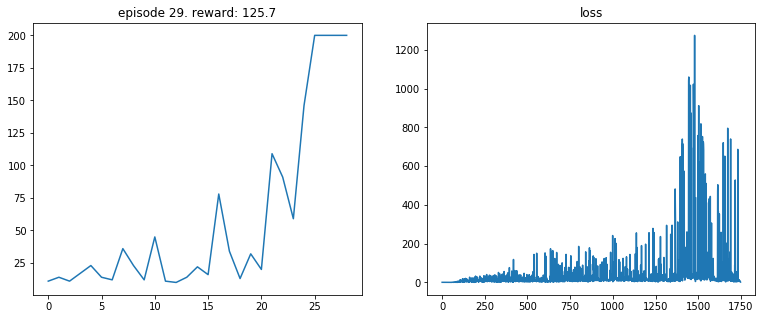

1874


In [11]:
EPISODE = 30

replay_initial = 50
target_update = 10

total_step = 1
all_episode_reward = []
losses = []

replay_buffer = Replay_Buffer(capacity=1000)
for e in range(EPISODE):
    print("EPISODE: {}".format(e+1))
    observation = env.reset()
    done = False
   
    step = 1
    episode_reward = 0
    frames = []
    
    while not done:
        
        # action 선택
        action = int(agent.get_action(observation))
        
        # 선택한 action으로 env.step()
        next_observation, reward, done, _ = env.step(action)
        step += 1
        total_step += 1
        episode_reward += reward
        
        # trajectory(S, A, R, S', done)를 Replay buffer에 저장 
        replay_buffer.add_sample(observation, action, reward, \
                                                       next_observation, done)
        
        observation = next_observation
        
        # 만약에 episode가 끝났으면 reward 저장
        if done:
            all_episode_reward.append(episode_reward)
        
        # replay buffer가 일정 이상 채워지면 학습 시작
        if len(replay_buffer) > replay_initial:
            loss = agent.train()
            losses.append(loss)
            
        # 일정 step마다 target Q 업데이트
        if total_step > replay_initial and total_step % target_update == 0:
            agent.update_target_network()
            
        # 그래프 그리기
        if total_step % 100 == 0:
            plot(step, e, all_episode_reward, losses)
            
    print(total_step)
    env.close()

### 학습된 DQN 테스트

EPISODE: 1
201



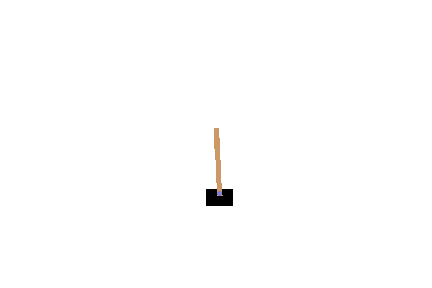
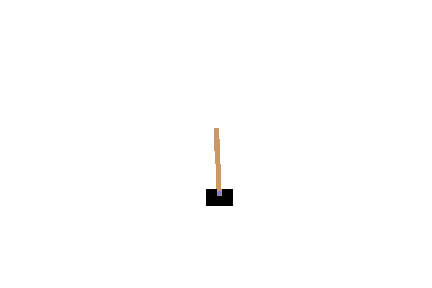
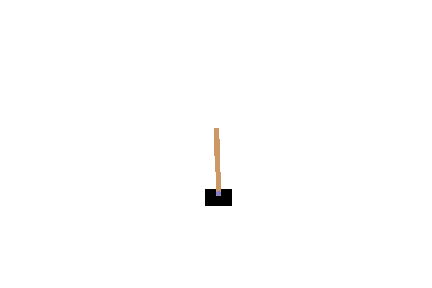
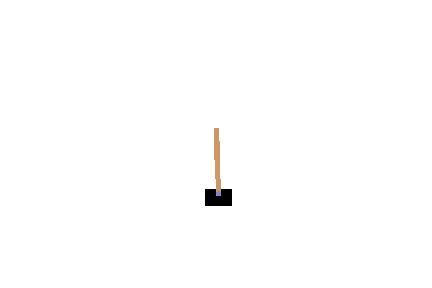
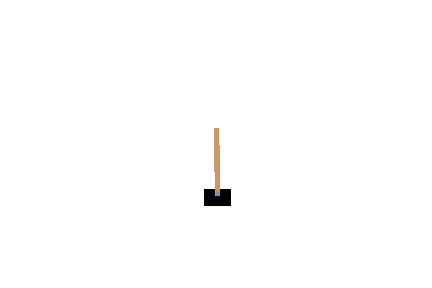
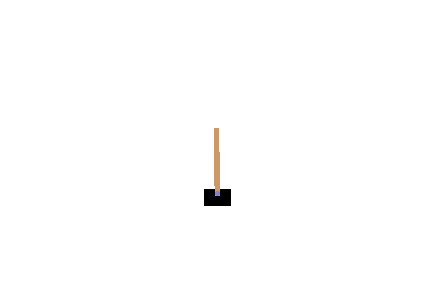
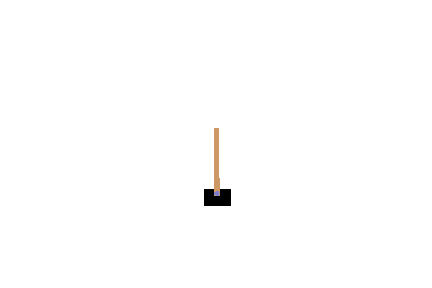
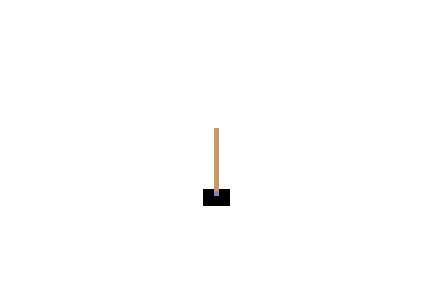
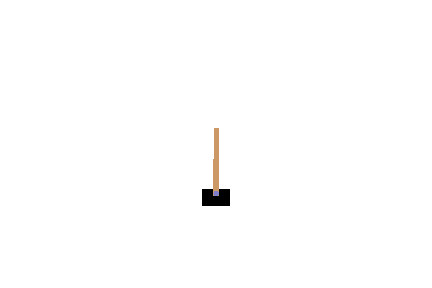
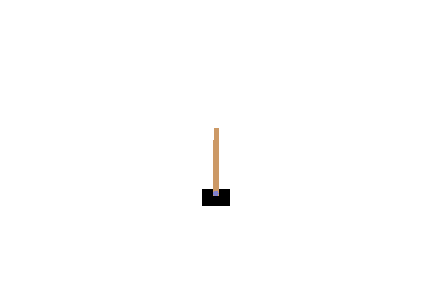
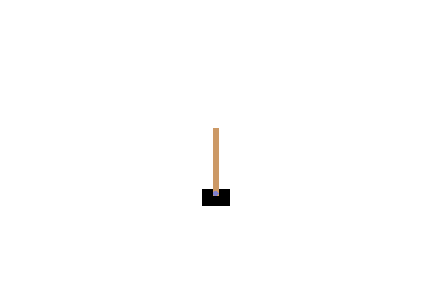
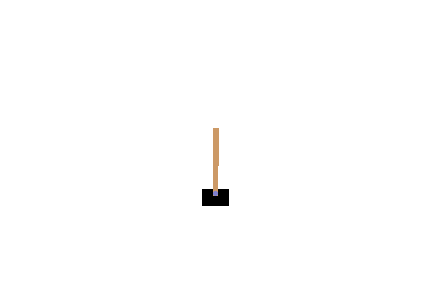
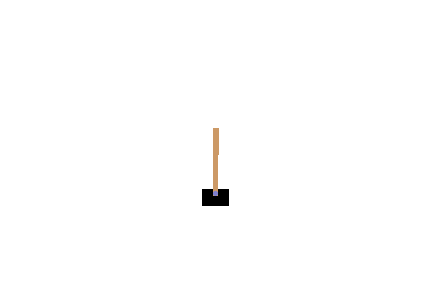
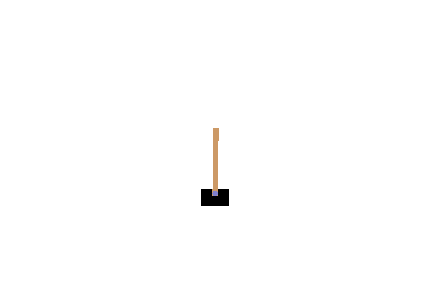
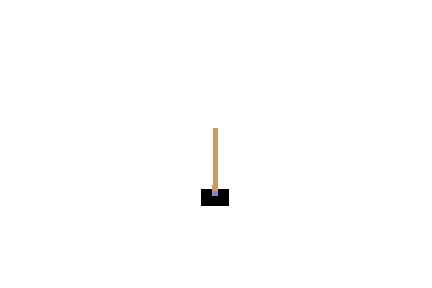
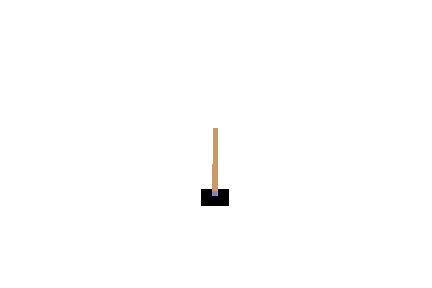
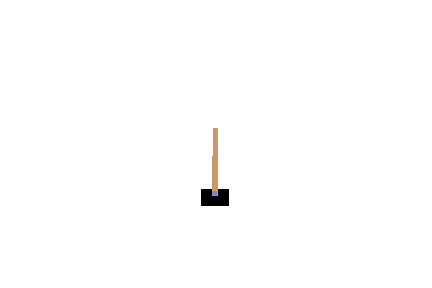
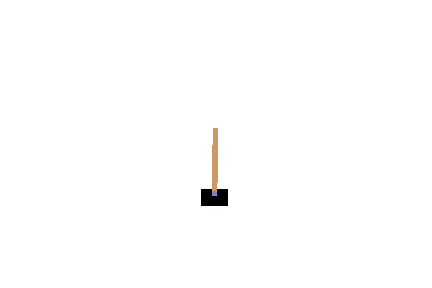
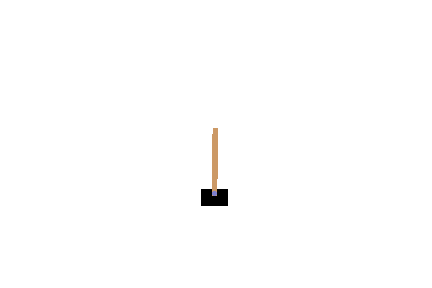
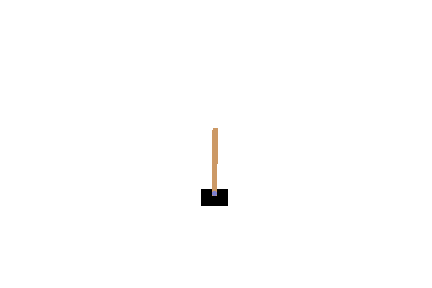
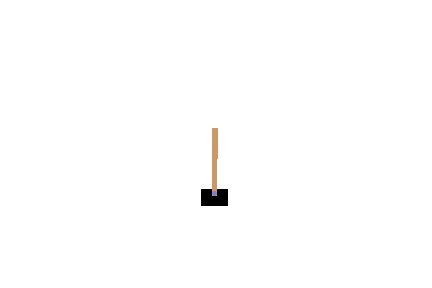
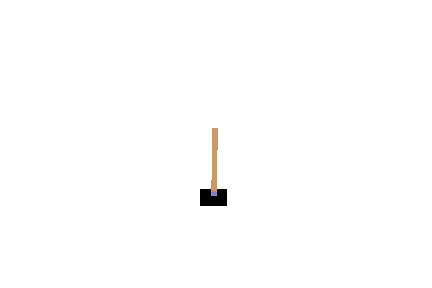
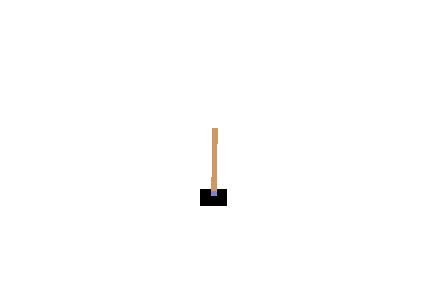
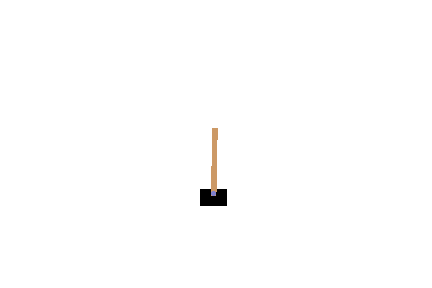
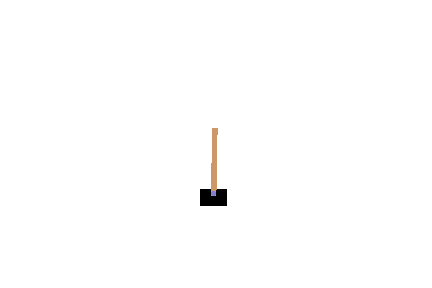
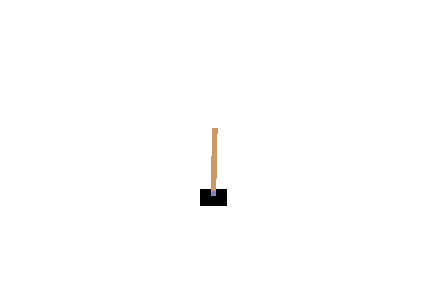
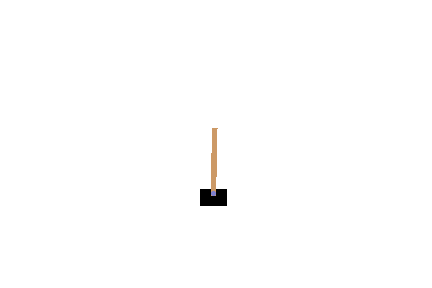
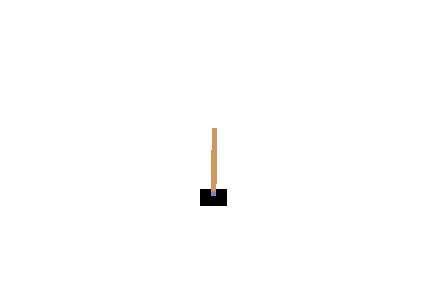
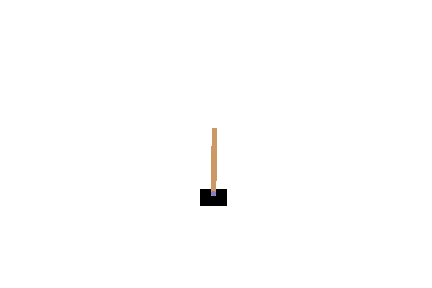
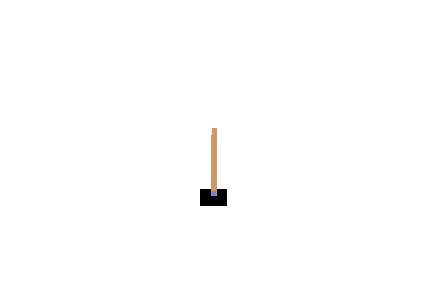
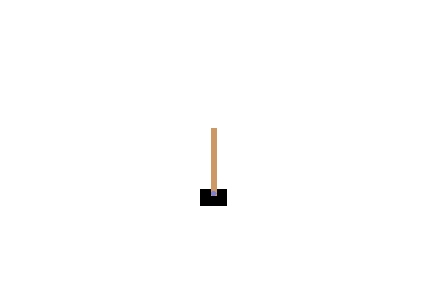
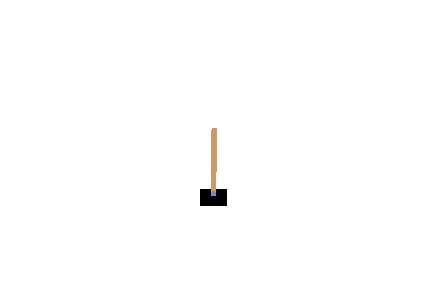
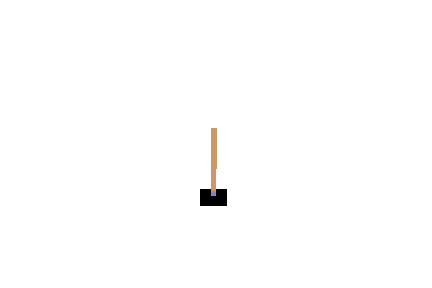
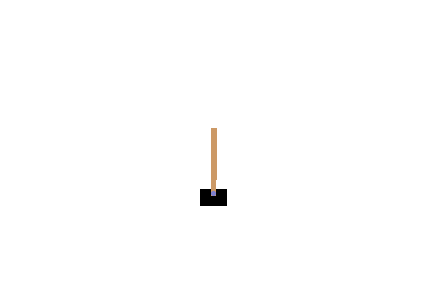
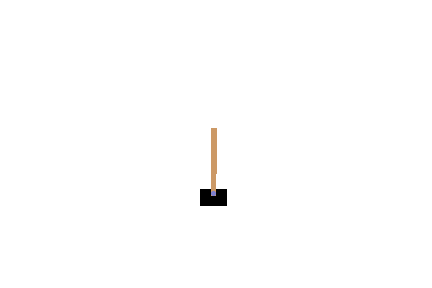
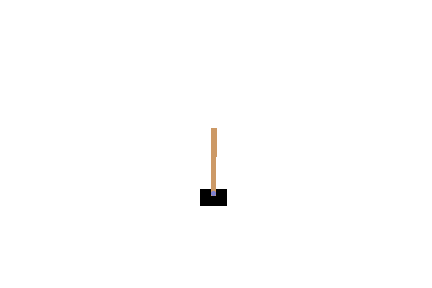
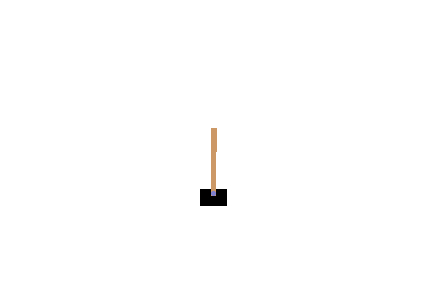
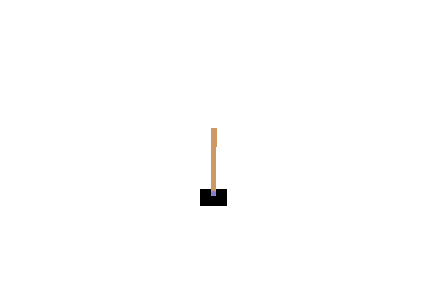
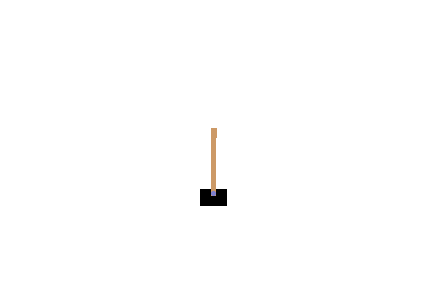
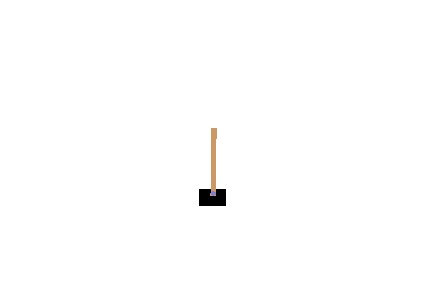
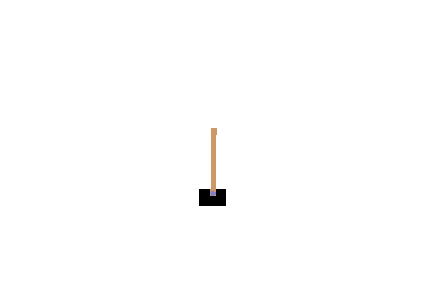
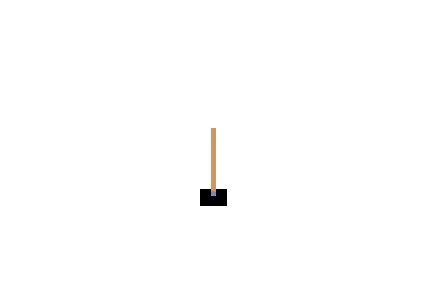
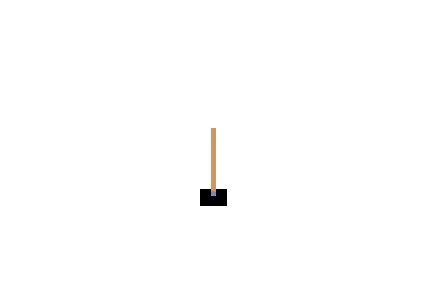
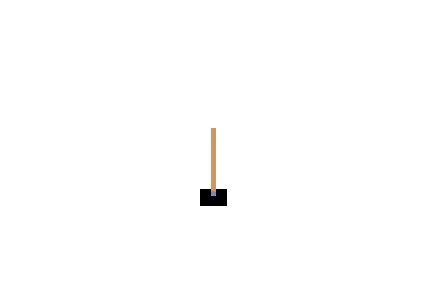
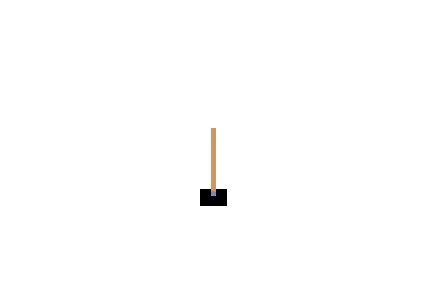
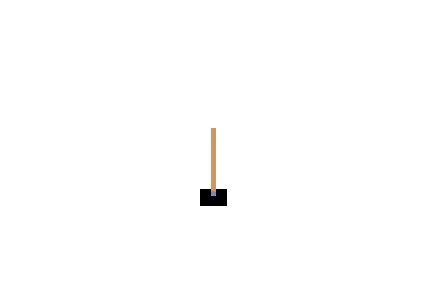
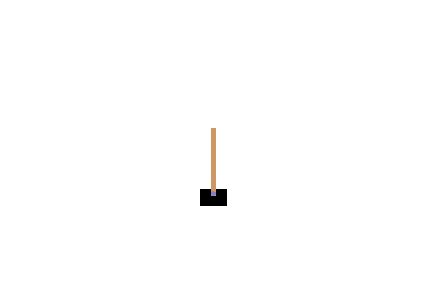
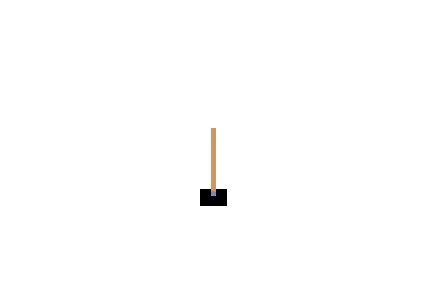
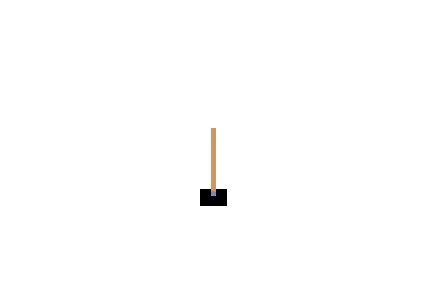
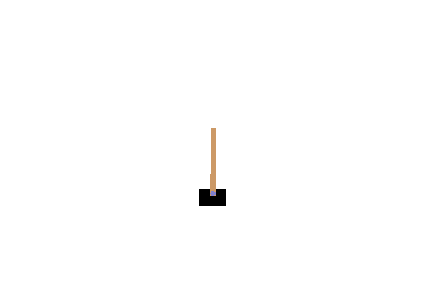
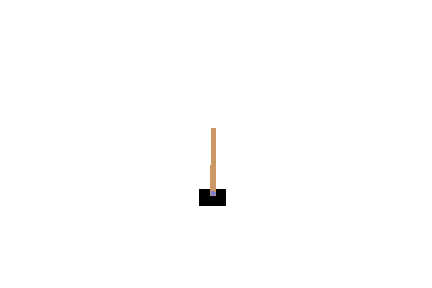
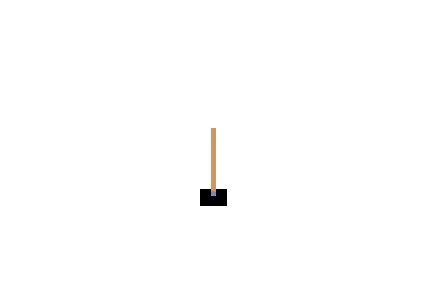
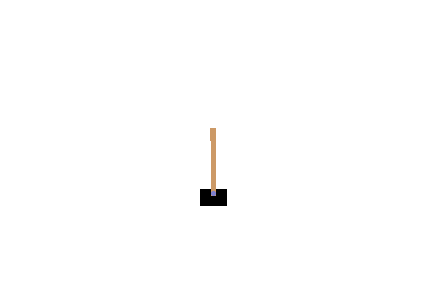
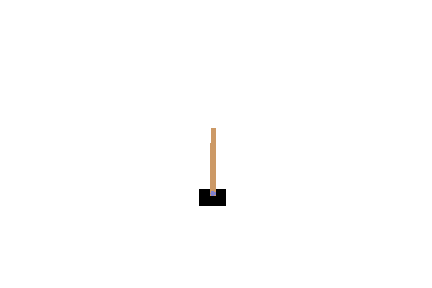
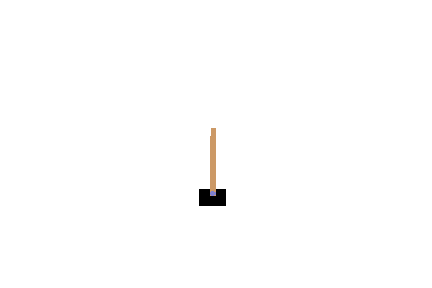
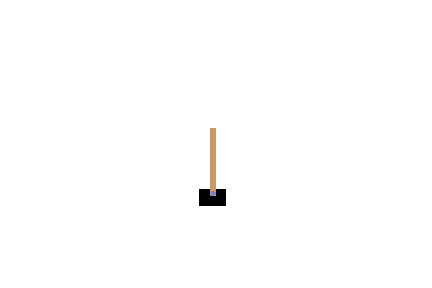
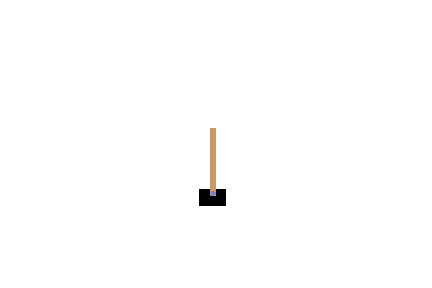
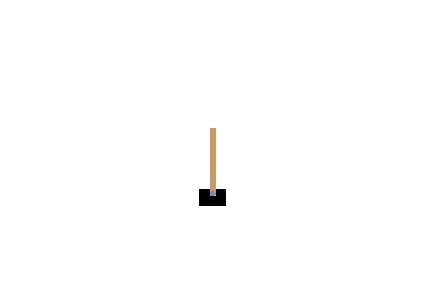
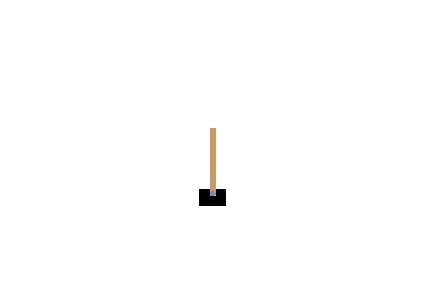
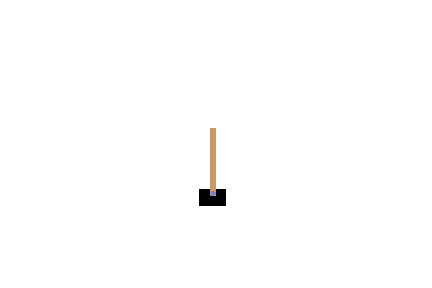
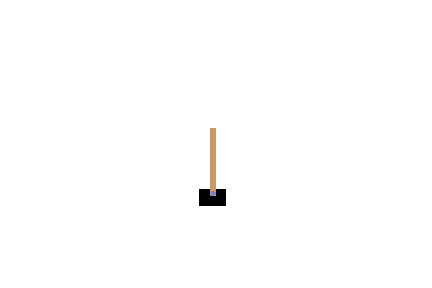
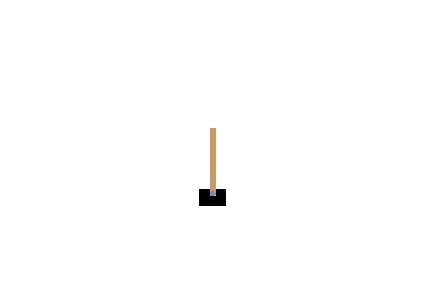
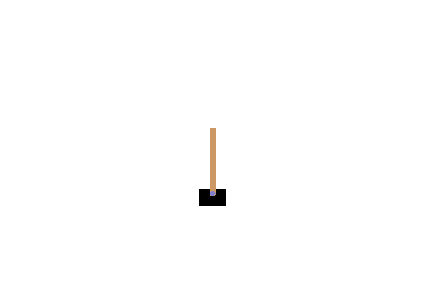
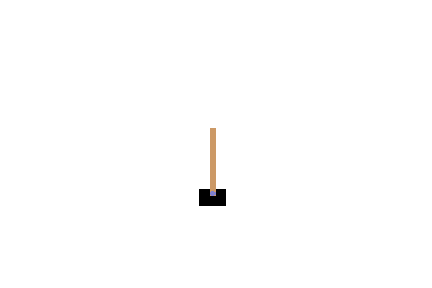
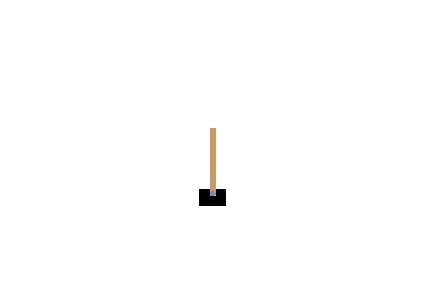
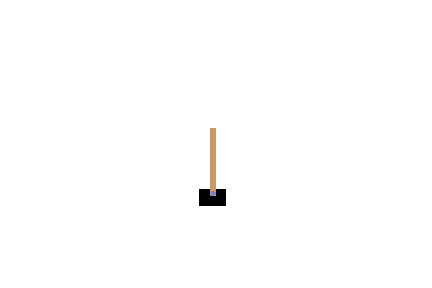
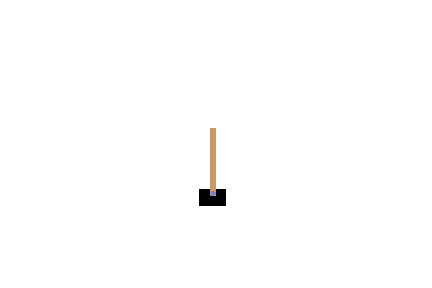
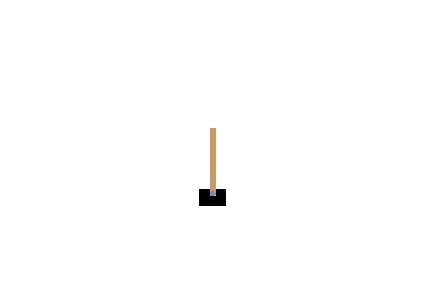
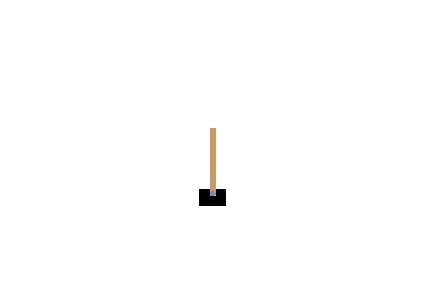
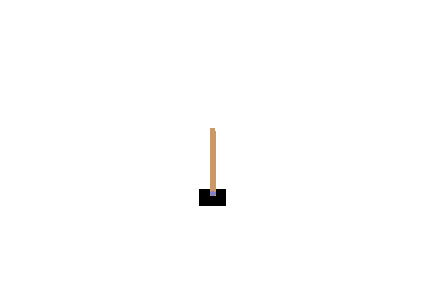
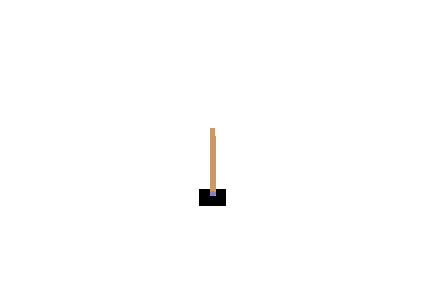
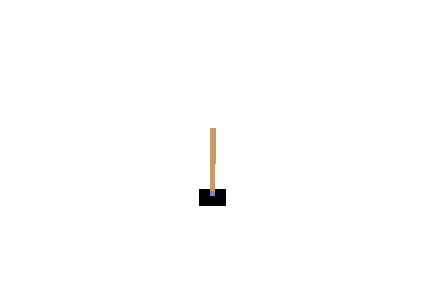
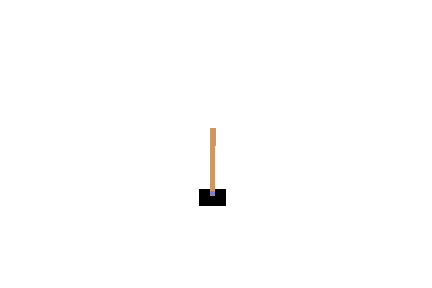
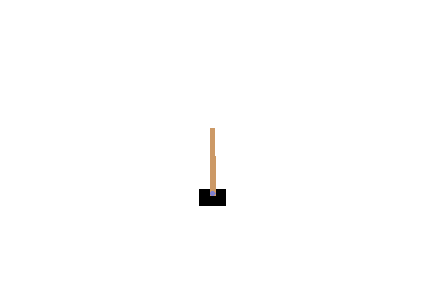
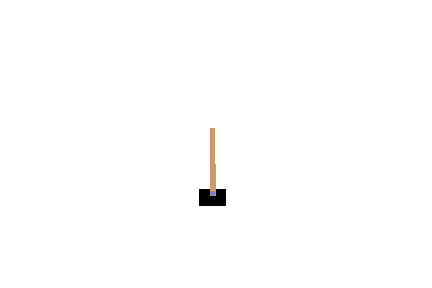
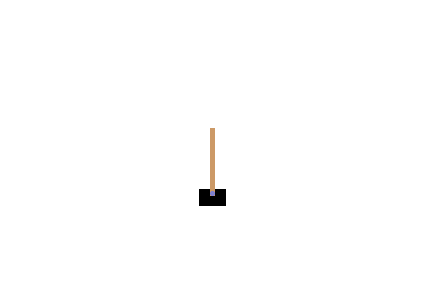
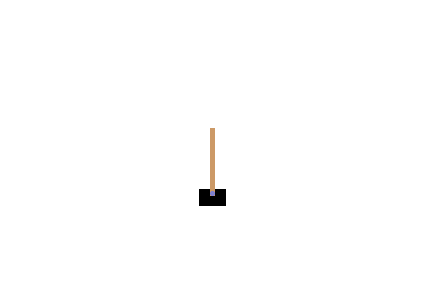
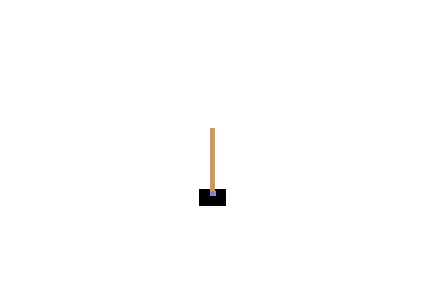
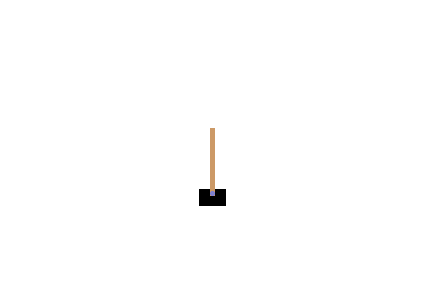
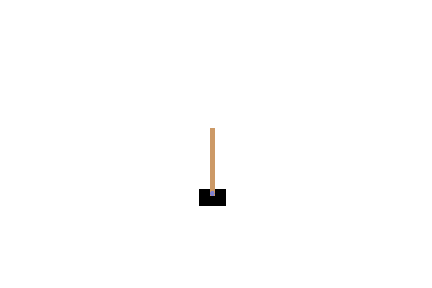
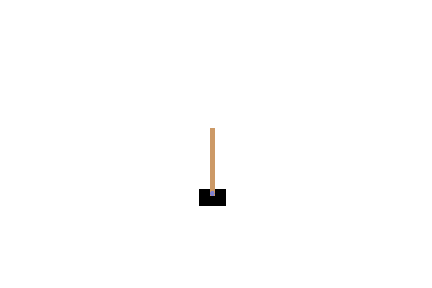
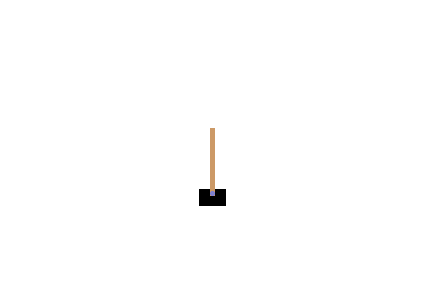
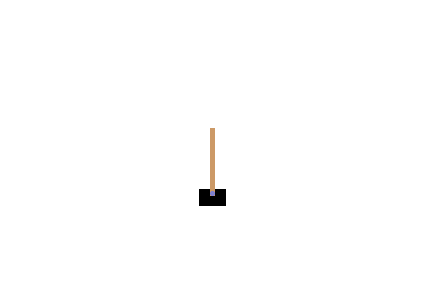
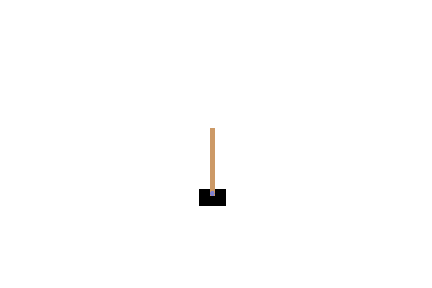
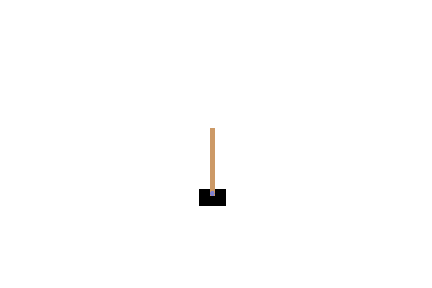
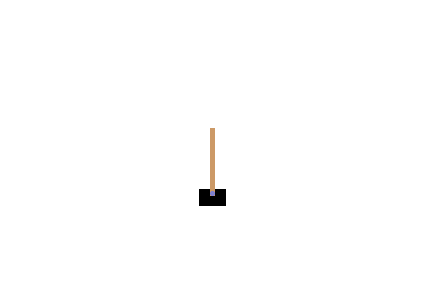
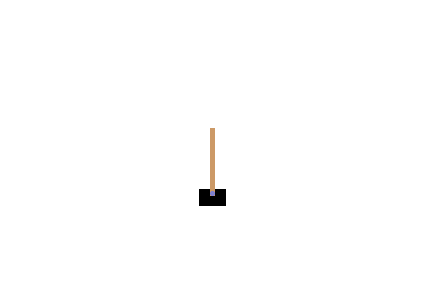
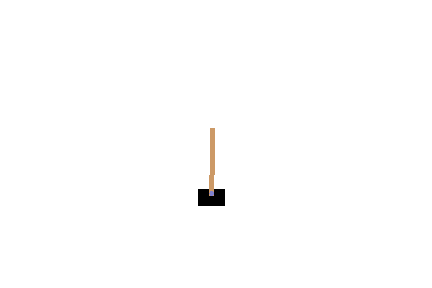
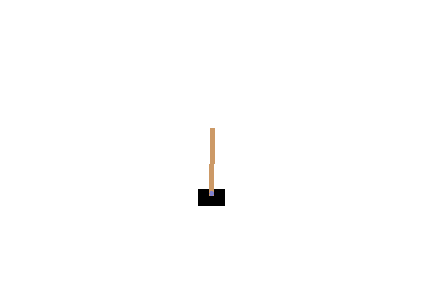
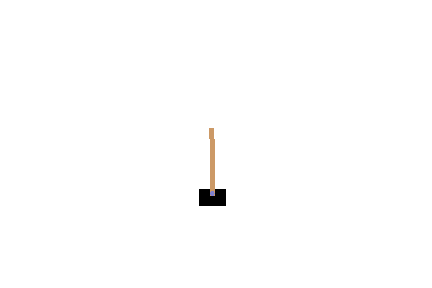
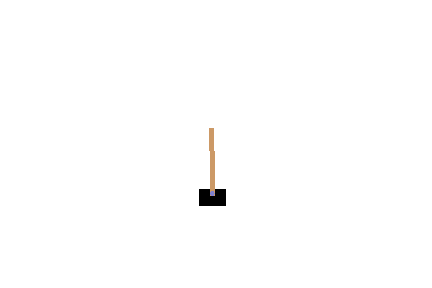
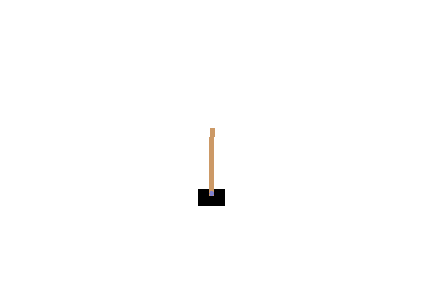
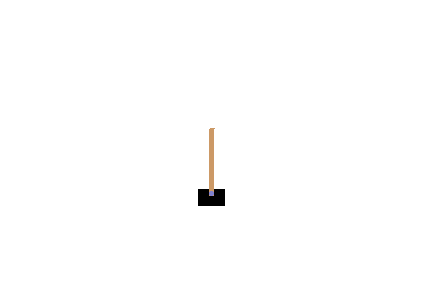
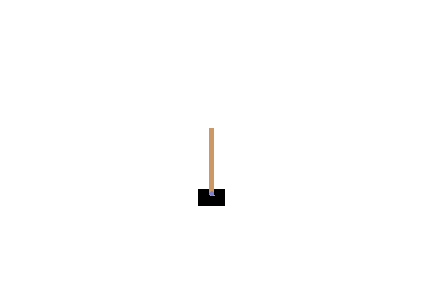
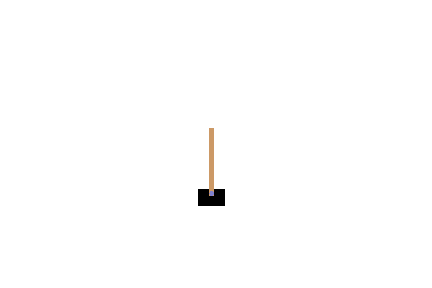
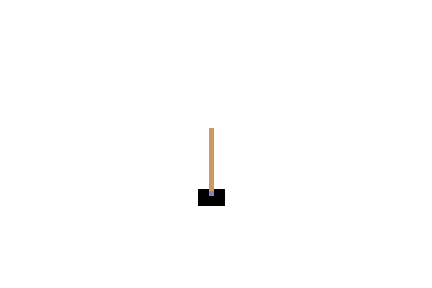
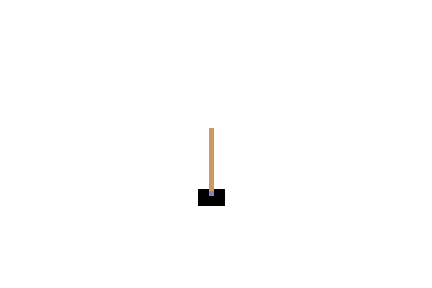
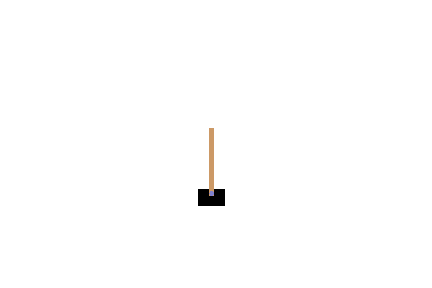
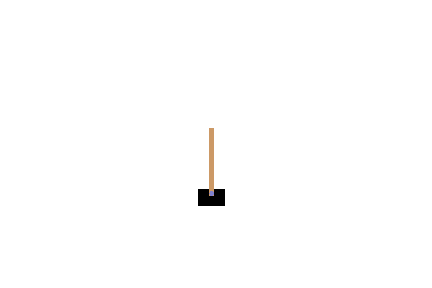
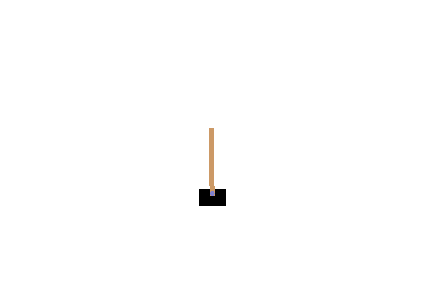
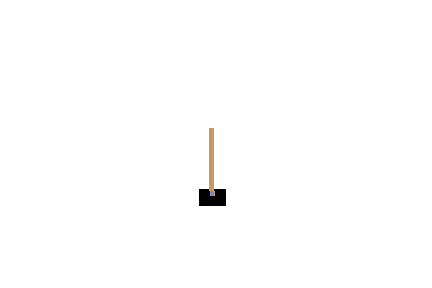
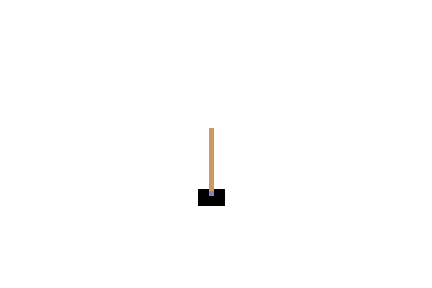
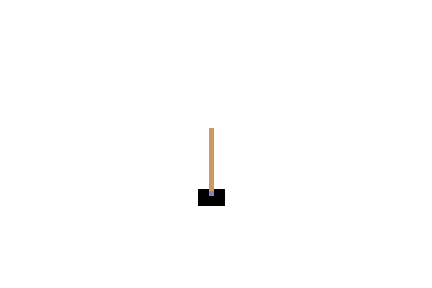
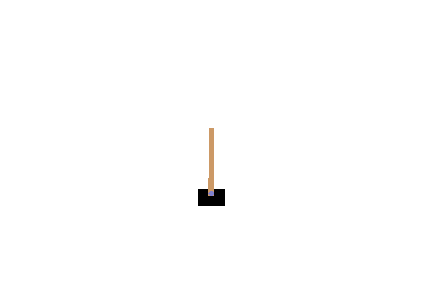
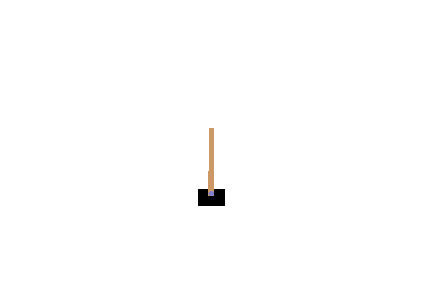
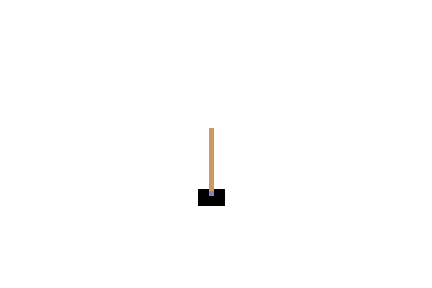
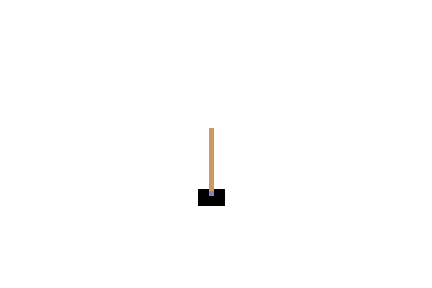
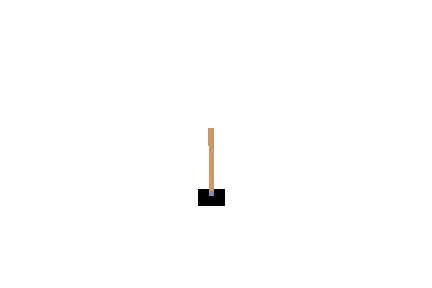
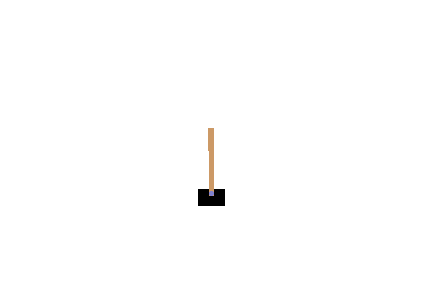
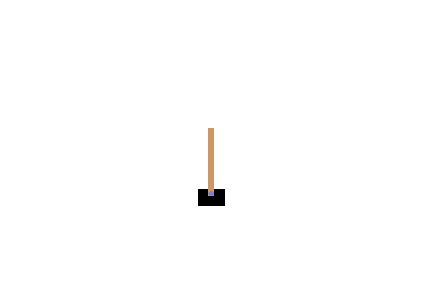
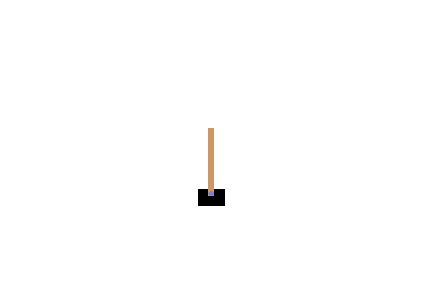
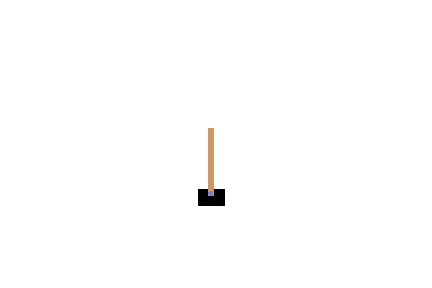
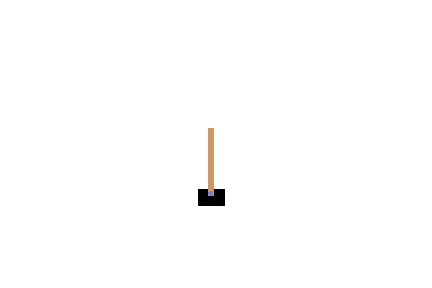
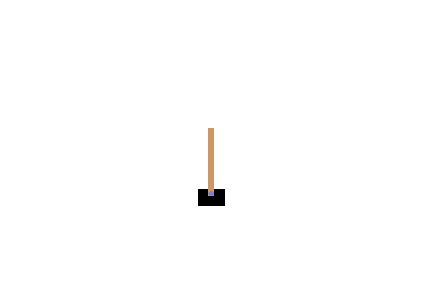
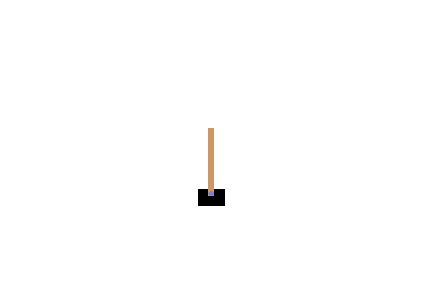
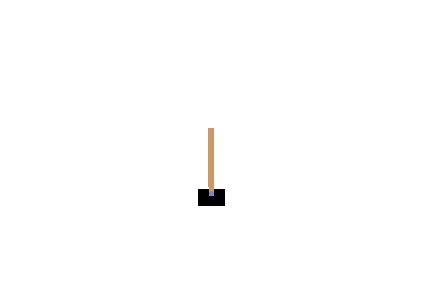
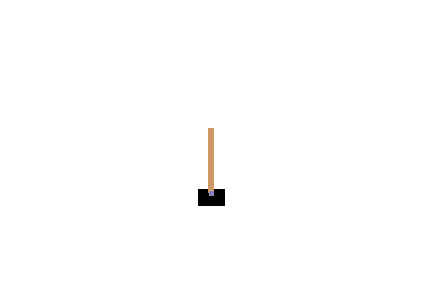
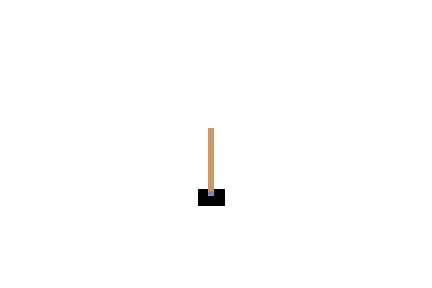
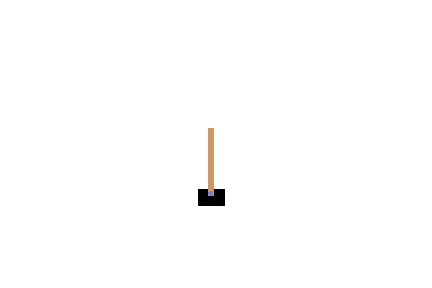
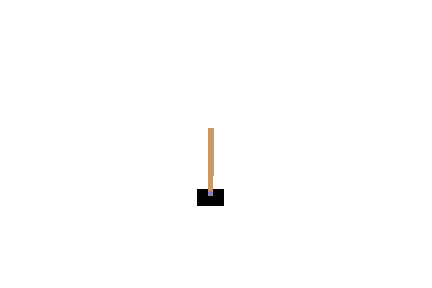
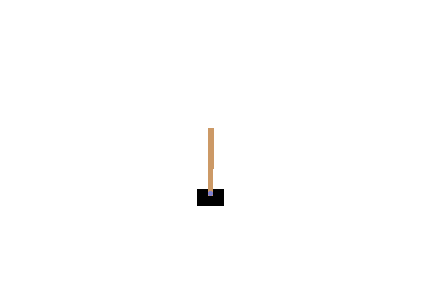
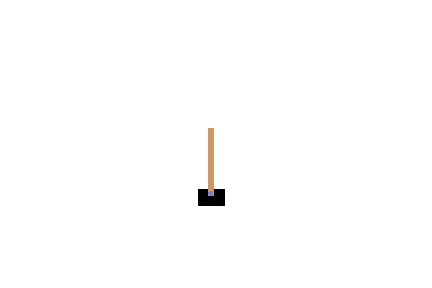
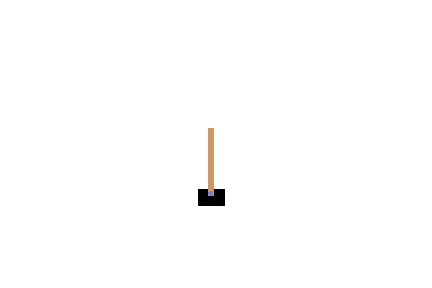
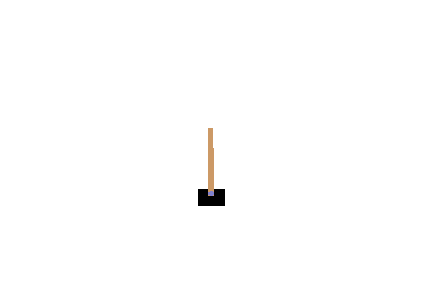
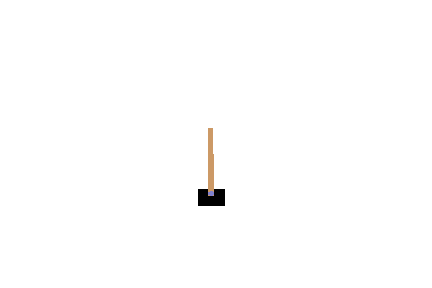
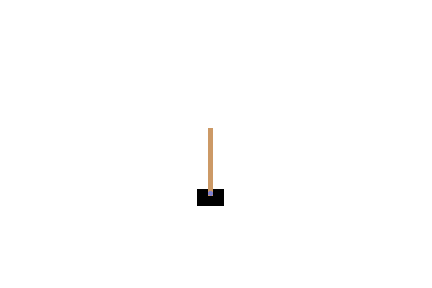
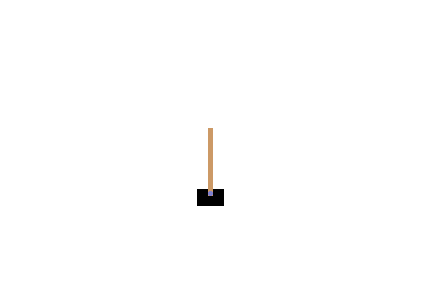
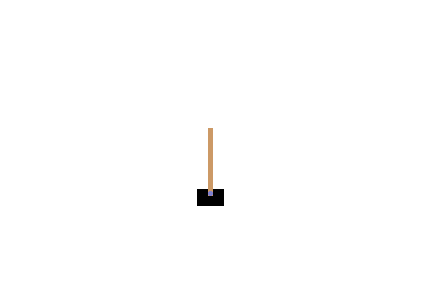
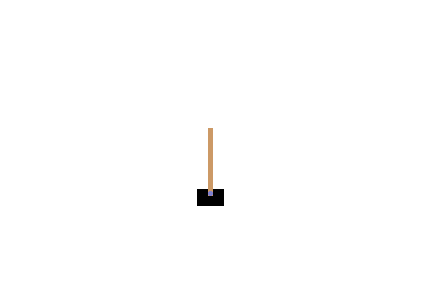
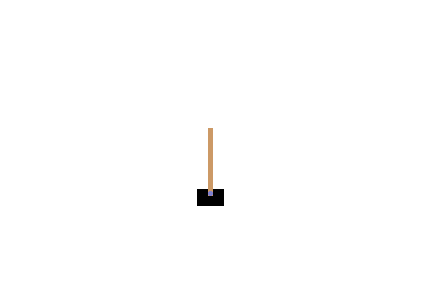
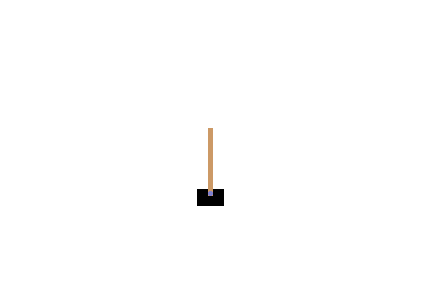
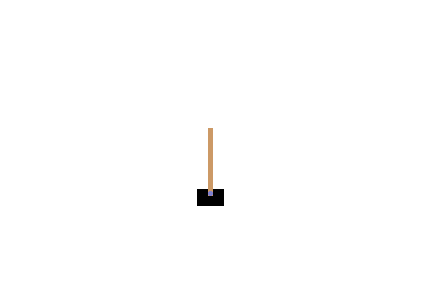
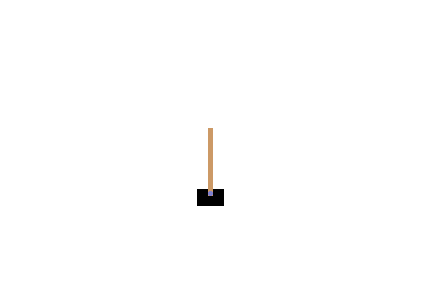
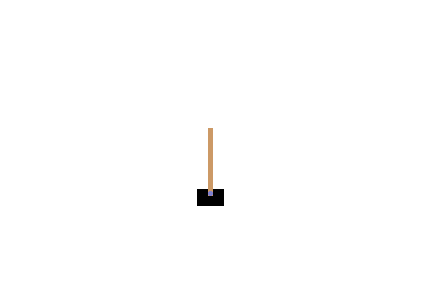
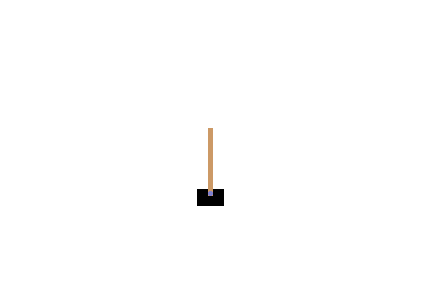
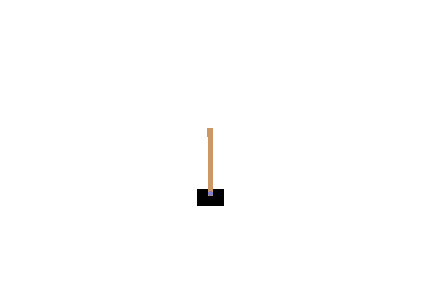
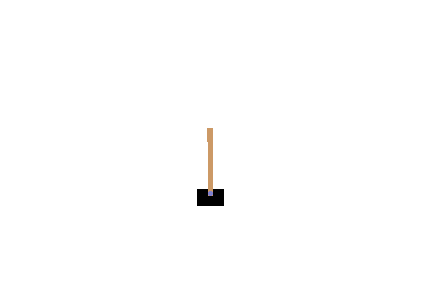
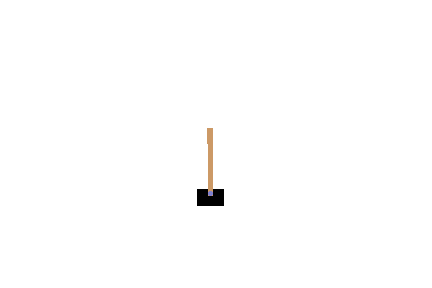
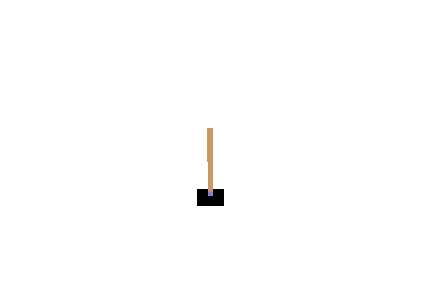
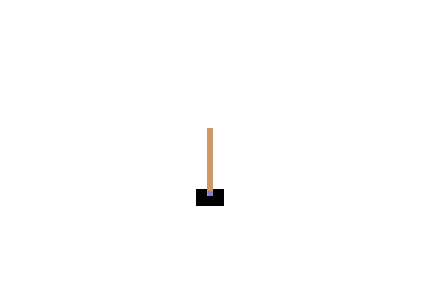
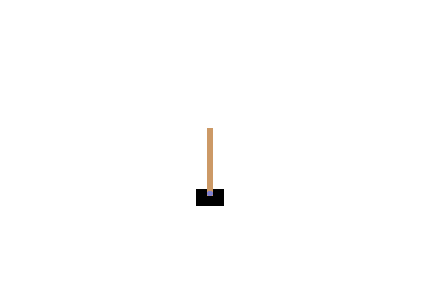
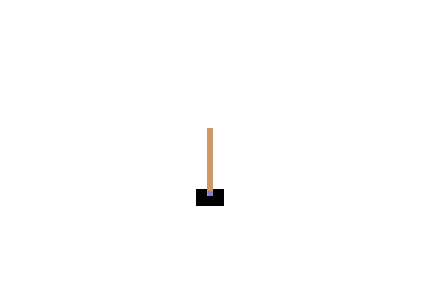
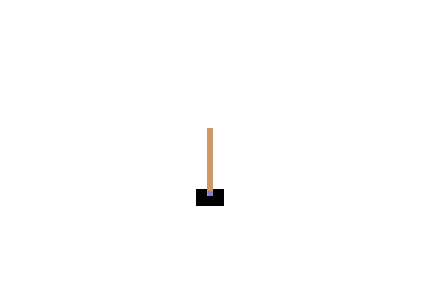
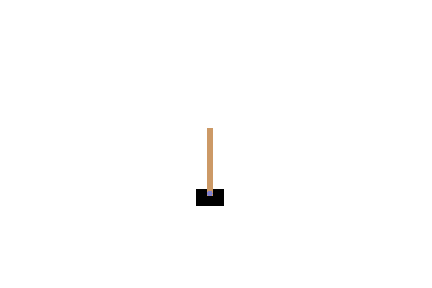
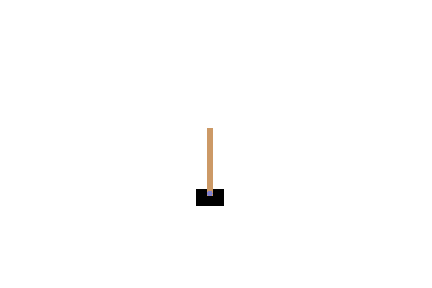
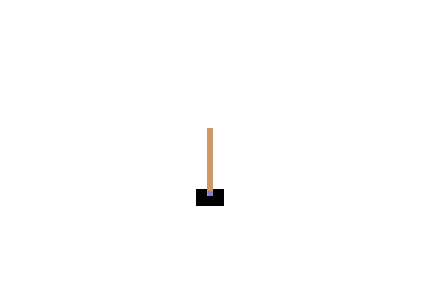
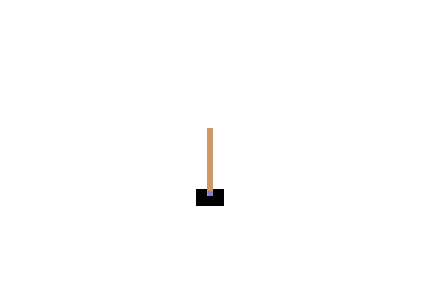
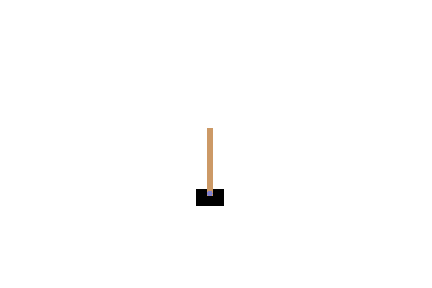
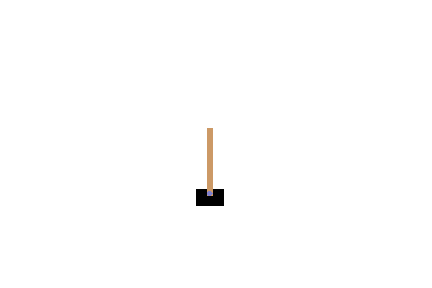
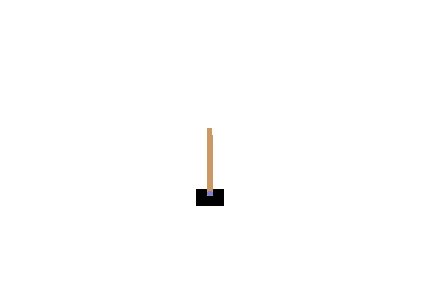
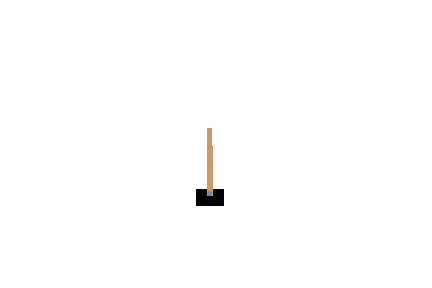
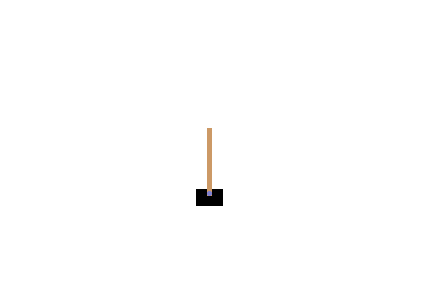
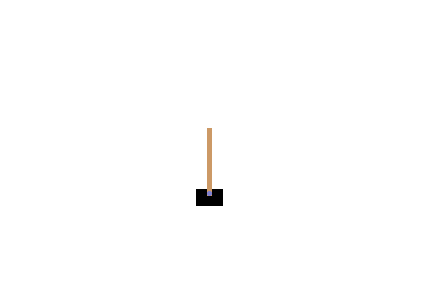
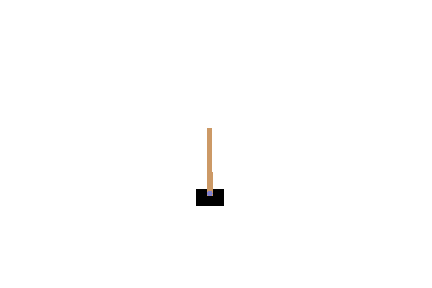
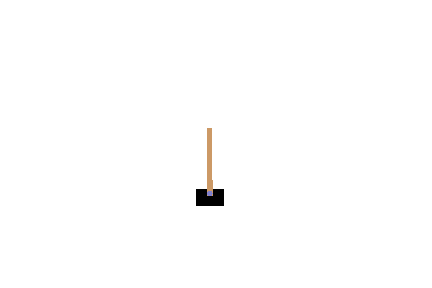
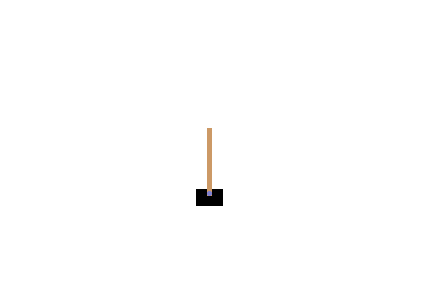
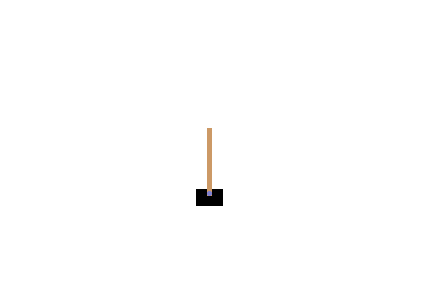
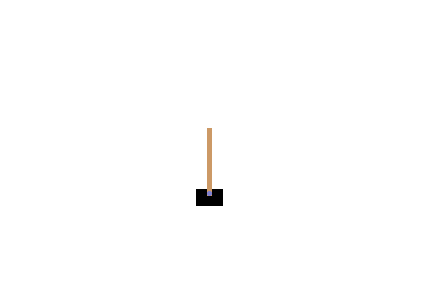
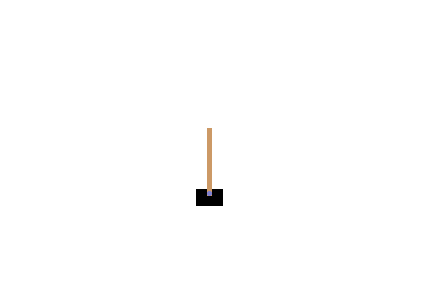
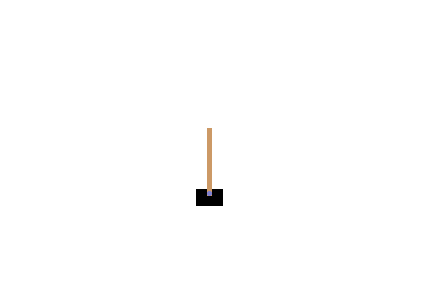
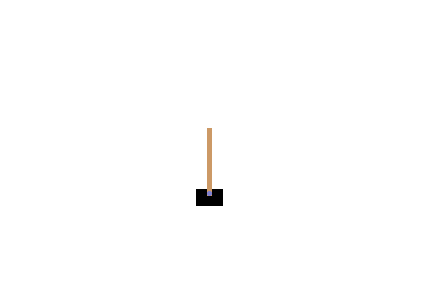
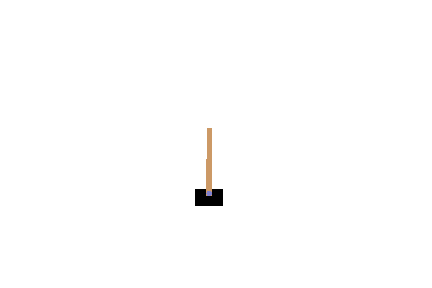
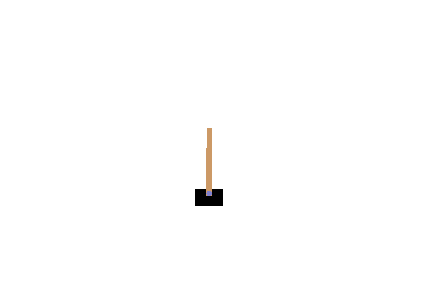
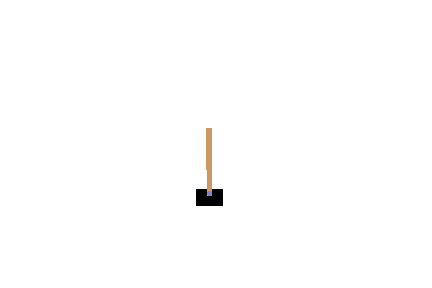
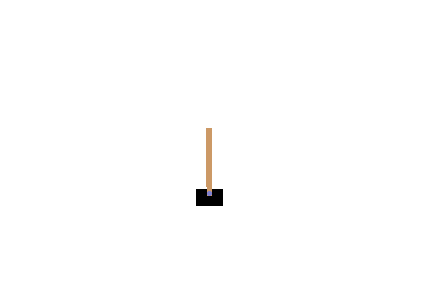
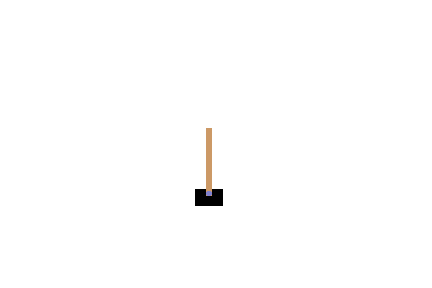
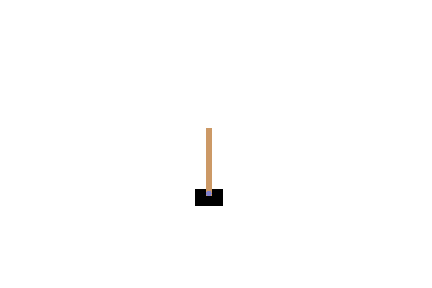
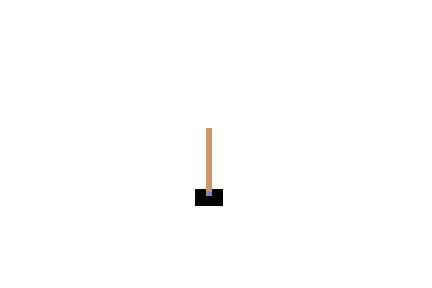
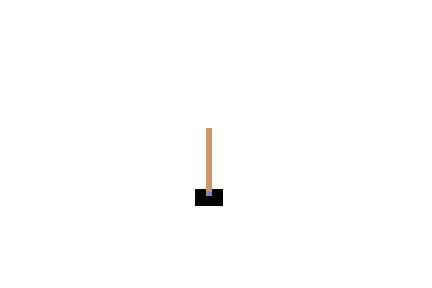
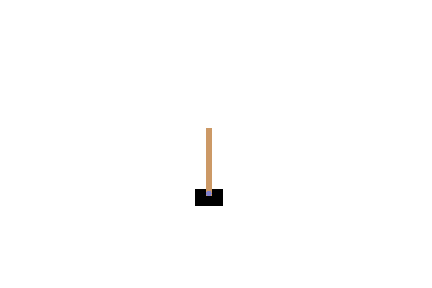
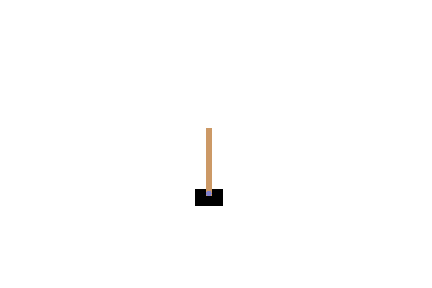
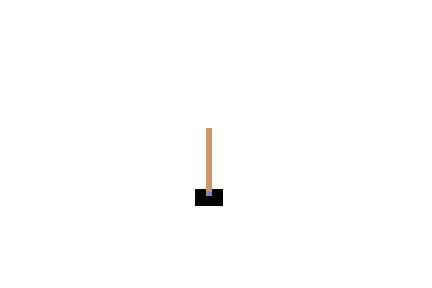
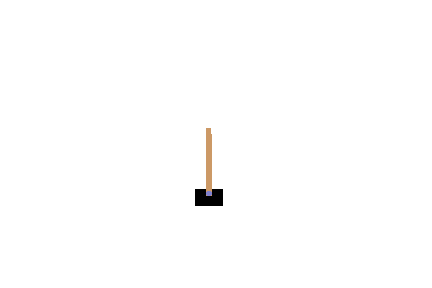
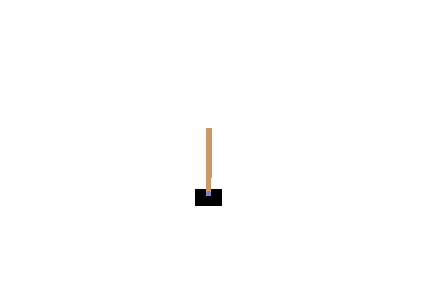
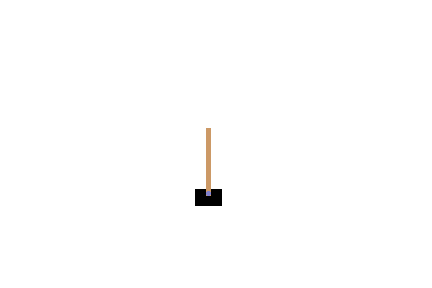
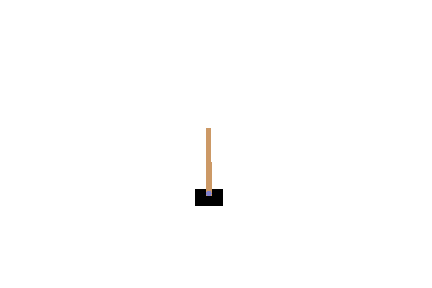
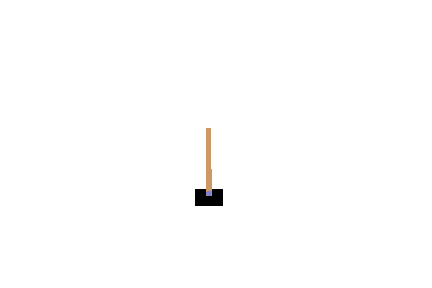
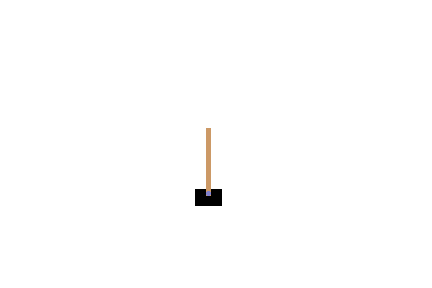
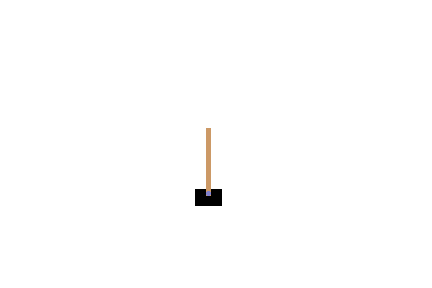
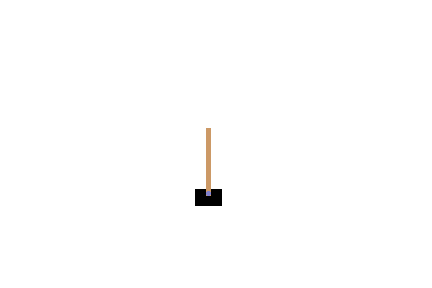
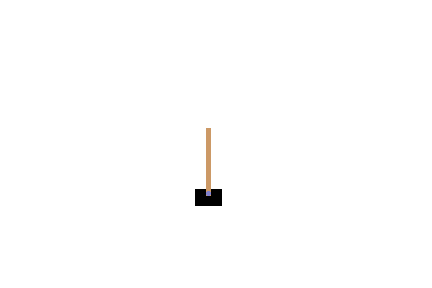
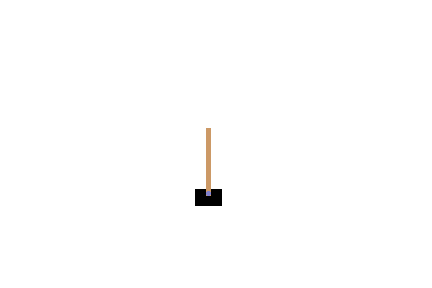
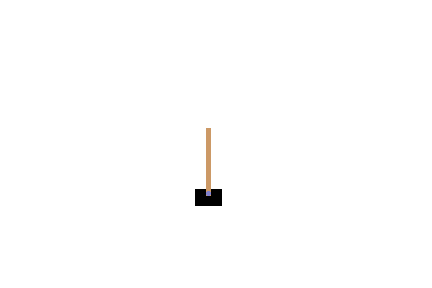
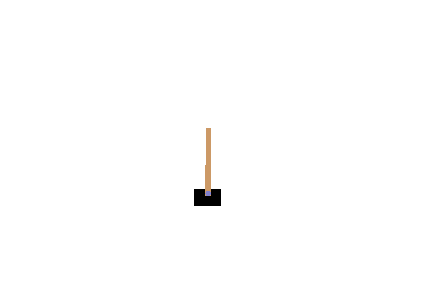
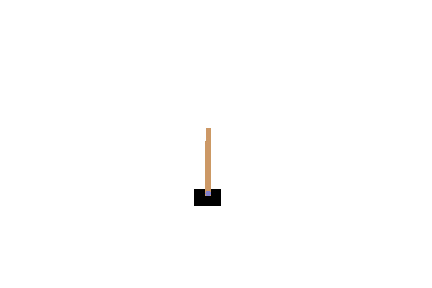
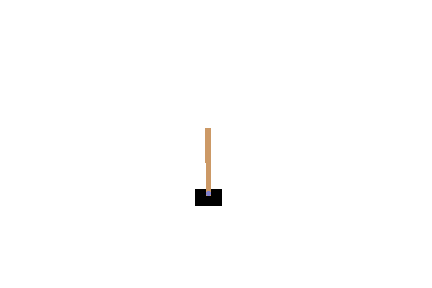
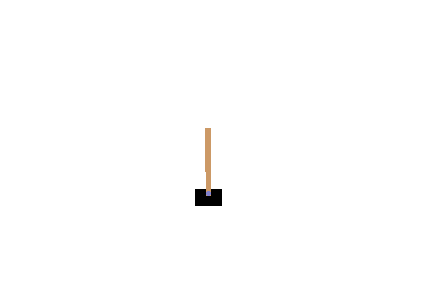
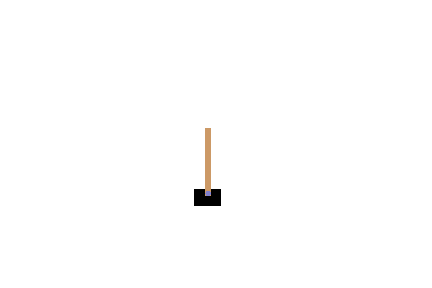
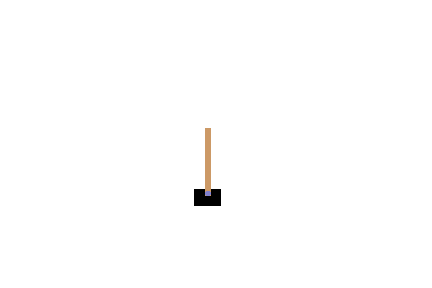
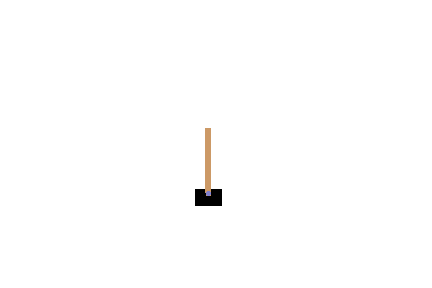
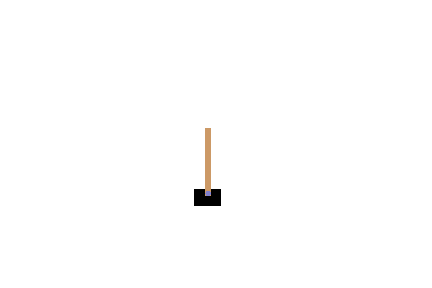
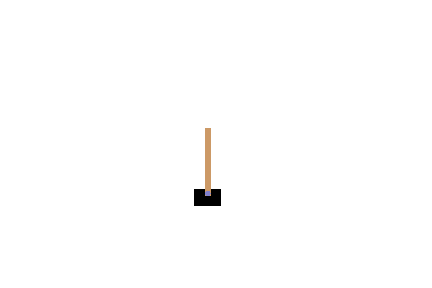
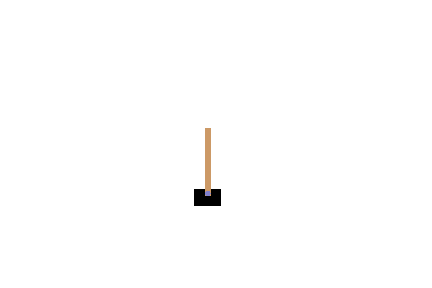
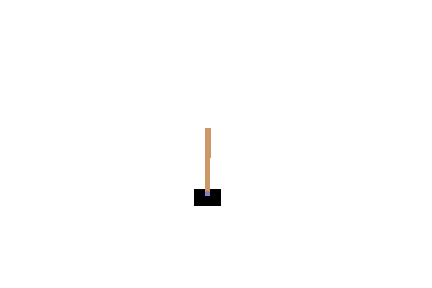
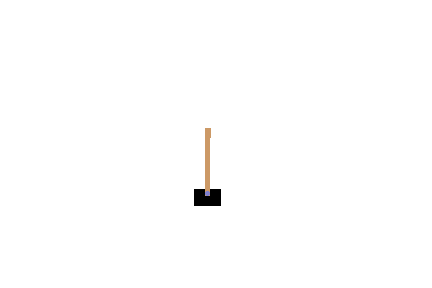
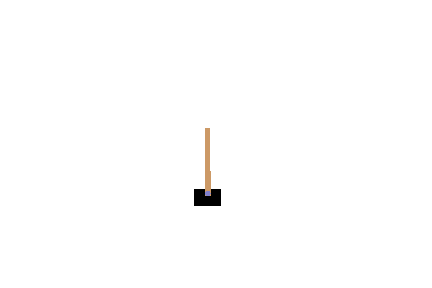
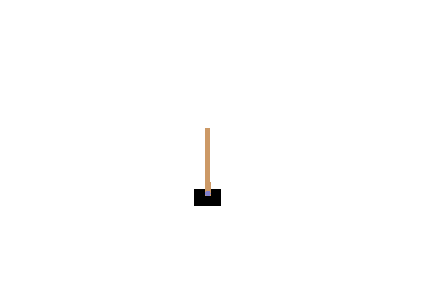
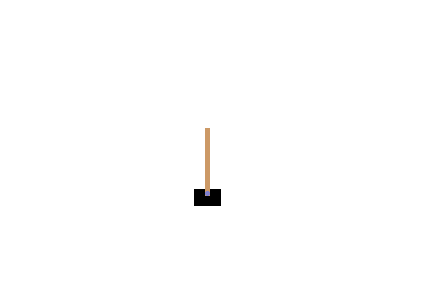
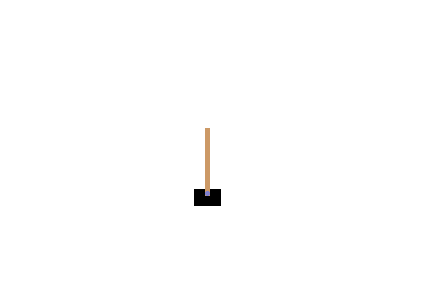
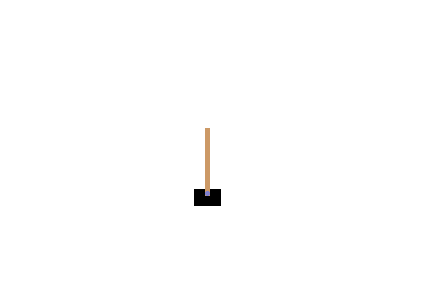

In [12]:
EPISODE = 1

all_episode_reward = []
losses = []

for e in range(EPISODE):
    print("EPISODE: {}".format(e+1))
    observation = env.reset()
    done = False
   
    step = 1
    episode_reward = 0
    frames = []
    
    while not done:
        action = int(agent.get_action(observation, is_play=True))
        
        next_observation, reward, done, _ = env.step(action)
        step += 1
        total_step += 1
        episode_reward += reward
        
        replay_buffer.add_sample(observation, action, reward, \
                                                       next_observation, done)
        
        observation = next_observation
        
        if done:
            all_episode_reward.append(episode_reward)
        
        # 게임화면 보여주기
        if e % 1 == 0:
            frames.append(env.render(mode = 'rgb_array'))
            
    env.close()
    print(step)
    if len(frames) > 0:
        display_frames_as_gif(frames)